# Predição de Séries Temporais com Redes Neurais Recorrentes
Neste notebook, vamos construir uma Rede Neural Recorrente (RNN) do tipo LSTM para prever séries temporais.
Os datasets que vamos utilizar são:
- Alcohol_Sales.csv
- Miles_Traveled.csv
- BeerWineLiquor.csv
Primeiro, vamos realizar uma Análise Exploratória de Dados (EDA) básica para entender melhor nossos dados.
Em seguida, vamos treinar nosso modelo LSTM e avaliar seu desempenho.
Também vamos comparar os resultados com algoritmos clássicos de séries temporais, como ARIMA e SARIMA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU
from keras.callbacks import ModelCheckpoint
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# Função para preparar os dados para o treinamento do modelo LSTM
def prepare_data(data, split_fraction, look_back):
    # Normalizando os dados
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Dividindo os dados em conjuntos de treinamento e teste
    train_size = int(len(data_scaled) * split_fraction)
    test_size = len(data_scaled) - train_size
    train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]

    # Criando o gerador de séries temporais
    train_generator = TimeseriesGenerator(train, train, length=look_back, batch_size=20)
    test_generator = TimeseriesGenerator(test, test, length=look_back, batch_size=1)

    return train_generator, test_generator, scaler

In [3]:
# Função para construir e treinar o modelo LSTM
def build_and_train_model(train_generator, input_shape):
    # Construindo o modelo LSTM
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Treinando o modelo
    model.fit_generator(train_generator, epochs=50)

    return model

In [4]:
def predict_and_inverse_transform(model, generator, scaler):
    predictions = model.predict_generator(generator)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [5]:
# Função para construir e treinar um modelo SimpleRNN
def build_and_train_simplernn_model(train_generator, input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit_generator(train_generator, epochs=10)
    return model

In [6]:
# Função para construir e treinar um modelo GRU
def build_and_train_gru_model(train_generator, input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit_generator(train_generator, epochs=10)
    return model

In [7]:
def train_ltsm(df_column):
    # Preparando os dados
    look_back = 12
    split_fraction = 0.8
    train_generator, test_generator, scaler = prepare_data(df_column.values.reshape(-1, 1), split_fraction, look_back)

    # Construindo e treinando o modelo LSTM
    model = build_and_train_model(train_generator, (look_back, 1))

    # Avaliando o modelo
    loss = model.evaluate_generator(test_generator)
    print('Test Loss: %.2f MSE' % (loss))
    
    return train_generator, test_generator, scaler, model, loss

In [8]:
def plot(df_column, model, test_generator, scaler, split_fraction=0.8, look_back=12):
    # Fazendo previsões
    predictions = predict_and_inverse_transform(model, test_generator, scaler)

    # Obtendo os valores reais
    real_values = df_column.values.reshape(-1, 1)
    real_values = real_values[int(split_fraction*len(real_values)) + look_back + 1:]

    # Plotando as previsões e os valores reais
    plt.figure(figsize=(16, 3))
    plt.plot(real_values, label='Real Values')
    plt.plot(predictions, label='Predicted Values')
    plt.legend()
    plt.show()

In [9]:
def plot_arima(df_column, predictions):
    # Fazendo previsões
    predictions = predictions

    # Obtendo os valores reais
    real_values = df_column.values.reshape(-1, 1)
    real_values = real_values[int(split_fraction*len(real_values)) + look_back + 1:]

    # Plotando as previsões e os valores reais
    plt.figure(figsize=(16, 3))
    plt.plot(real_values, label='Real Values')
    plt.plot(predictions, label='Predicted Values')
    plt.legend()
    plt.show()

In [10]:
def train_sarima(train_generator, test_generator):
    # Construindo e treinando o modelo SARIMA
    sarima_model = SARIMAX(train_generator.data, order=(5,1,0), seasonal_order=(1,1,1,12))
    sarima_model_fit = sarima_model.fit()

    # Fazendo previsões
    sarima_predictions = sarima_model_fit.predict(start=len(train_generator.data), end=len(train_generator.data) + len(test_generator.data)-1)

    # Calculando o erro
    sarima_mse = mean_squared_error(test_generator.data, sarima_predictions)
    print('Test Loss for SARIMA: %.2f MSE' % (sarima_mse))
    
    return sarima_model, sarima_model_fit, sarima_predictions

In [11]:
def train_arima(train_generator, test_generator):
    # Construindo e treinando o modelo ARIMA
    arima_model = ARIMA(train_generator.data, order=(1,1,0))
    arima_model_fit = arima_model.fit()

    # Fazendo previsões
    arima_predictions = arima_model_fit.predict(start=len(train_generator.data), end=len(train_generator.data) + len(test_generator.data)-1)

    # Calculando o erro
    arima_mse = mean_squared_error(test_generator.data, arima_predictions)
    print('Test Loss for ARIMA: %.2f MSE' % (arima_mse))

    return arima_model, arima_model_fit, arima_predictions

In [12]:
look_back=12
split_fraction=0.8

# alcohol_sales

## eda

In [13]:
# Carregando os datasets
alcohol_sales = pd.read_csv('./data/Alcohol_Sales.csv')

Alcohol Sales Dataset:
         DATE  S4248SM144NCEN
0  1992-01-01            3459
1  1992-02-01            3458
2  1992-03-01            4002
3  1992-04-01            4564
4  1992-05-01            4221
       S4248SM144NCEN
count      325.000000
mean      7886.400000
std       2914.269061
min       3031.000000
25%       5231.000000
50%       7481.000000
75%       9977.000000
max      15504.000000


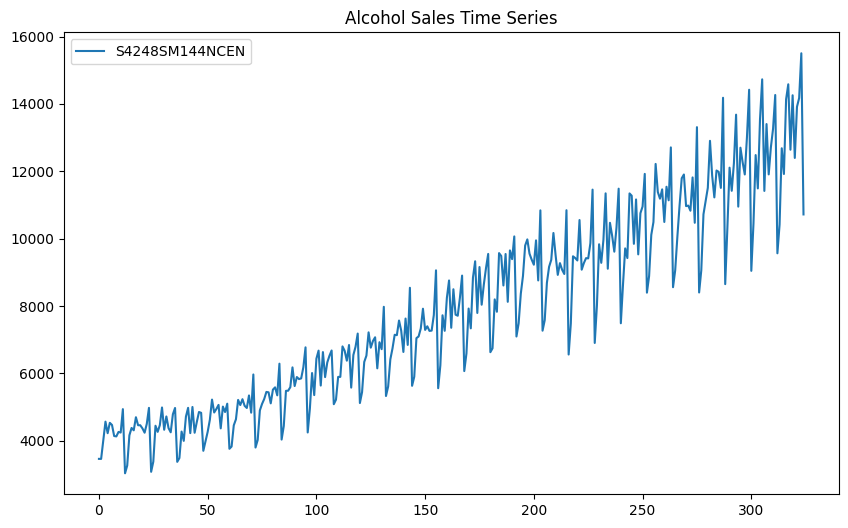

In [14]:
# Dataset alcohol_sales
print('Alcohol Sales Dataset:')
print(alcohol_sales.head())
print(alcohol_sales.describe())
plt.figure(figsize=(10, 6))
sns.lineplot(data=alcohol_sales)
plt.title('Alcohol Sales Time Series')
plt.show()

## lstm

Epoch 1/50


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3697244598.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=50)


13/13 [==============================] - 1s 5ms/step - loss: 0.1083
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 8/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 10/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 11/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 12/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 13/50
13/13 [==============================] - 0s 5ms/

C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2619419817.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = model.evaluate_generator(test_generator)


Test Loss: 0.01 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


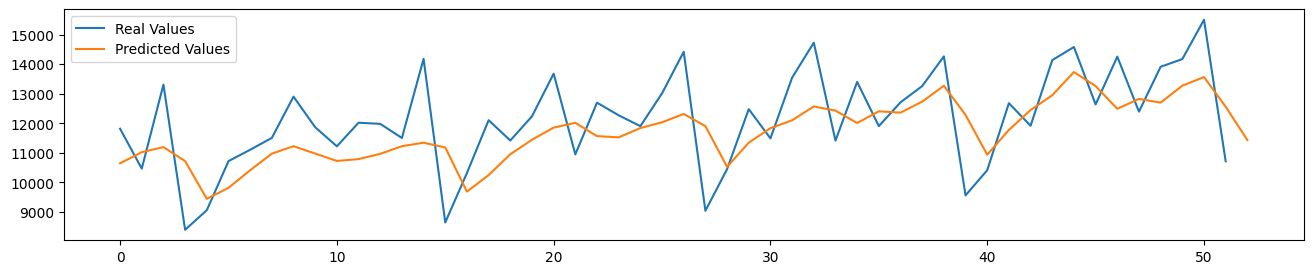

In [15]:
train_generator, test_generator, scaler, model, loss = train_ltsm(alcohol_sales['S4248SM144NCEN'])
plot(alcohol_sales['S4248SM144NCEN'], model, test_generator, scaler)

## simplern

Epoch 1/10


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\1371248519.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=10)


13/13 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 4/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 5/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 6/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 8/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 9/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 10/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0018


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3241824288.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = simplernn_model.evaluate_generator(test_generator)


Test Loss for SimpleRNN: 0.00 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


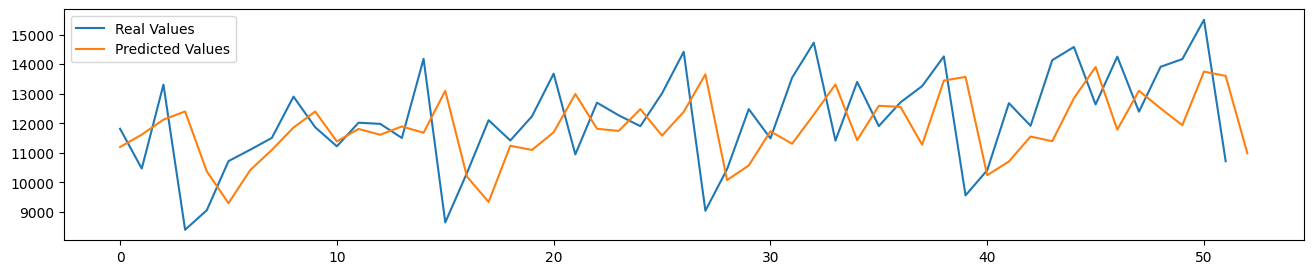

In [16]:
# Construindo e treinando o modelo SimpleRNN
simplernn_model = build_and_train_simplernn_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = simplernn_model.evaluate_generator(test_generator)
print('Test Loss for SimpleRNN: %.2f MSE' % (loss))

plot(alcohol_sales['S4248SM144NCEN'], simplernn_model, test_generator, scaler)

## gru

Epoch 1/10


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3167918330.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=10)


13/13 [==============================] - 1s 4ms/step - loss: 0.0930
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 7/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 8/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 9/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 10/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0058


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2703017206.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = gru_model.evaluate_generator(test_generator)


Test Loss for GRU: 0.02 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


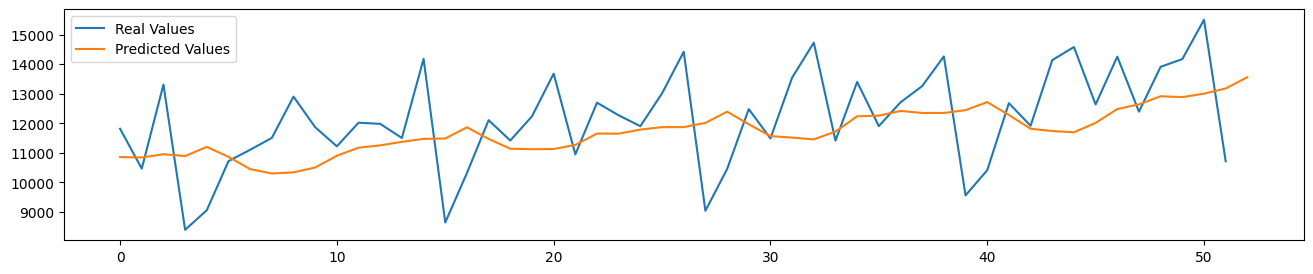

In [17]:
# Construindo e treinando o modelo GRU
gru_model = build_and_train_gru_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = gru_model.evaluate_generator(test_generator)
print('Test Loss for GRU: %.2f MSE' % (loss))

plot(alcohol_sales['S4248SM144NCEN'], gru_model, test_generator, scaler)

## arima

Test Loss for ARIMA: 0.02 MSE


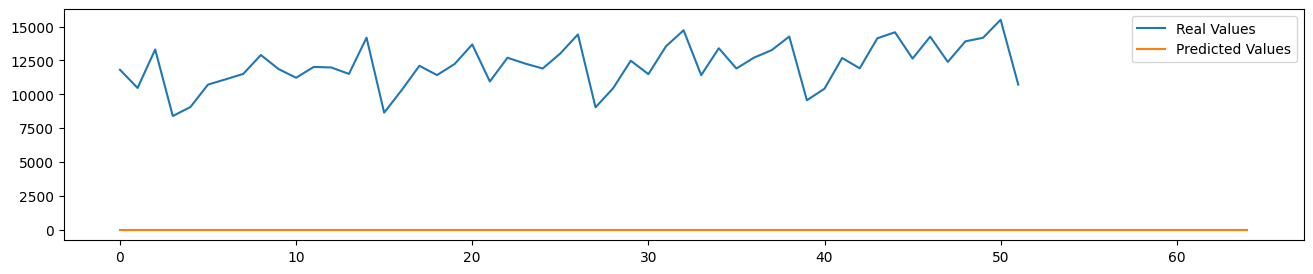

In [18]:
arima_model, arima_model_fit, arima_predictions = train_arima(train_generator, test_generator)
plot_arima(alcohol_sales['S4248SM144NCEN'], arima_predictions)

## sarima

Test Loss for SARIMA: 0.00 MSE


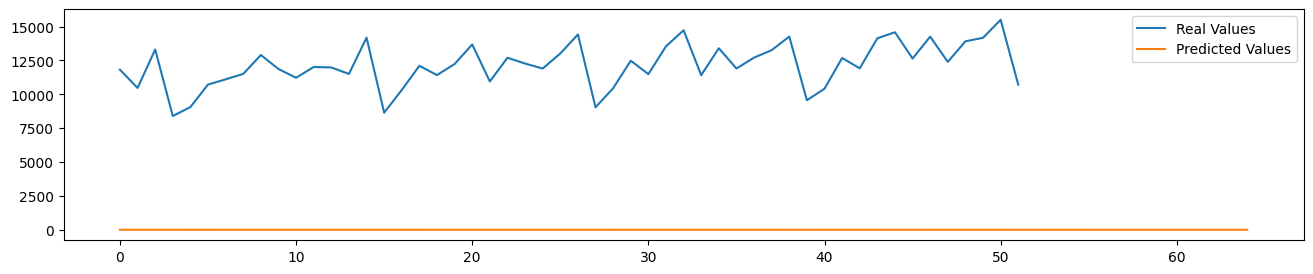

In [19]:
sarima_model, sarima_model_fit, sarima_predictions = train_sarima(train_generator, test_generator)
plot_arima(alcohol_sales['S4248SM144NCEN'], sarima_predictions)

# beer_wine_liquor

## eda

In [20]:
beer_wine_liquor = pd.read_csv('./data/BeerWineLiquor.csv')

Beer Wine Liquor Dataset:
       date  beer
0  1/1/1992  1509
1  2/1/1992  1541
2  3/1/1992  1597
3  4/1/1992  1675
4  5/1/1992  1822
              beer
count   324.000000
mean   2972.895062
std    1010.218574
min    1501.000000
25%    2109.000000
50%    2791.000000
75%    3627.250000
max    6370.000000


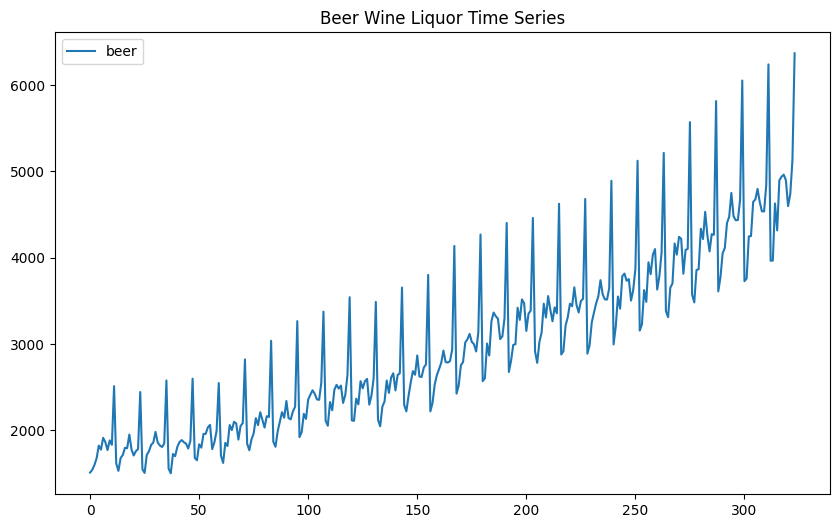

In [21]:
# Dataset beer_wine_liquor
print('Beer Wine Liquor Dataset:')
print(beer_wine_liquor.head())
print(beer_wine_liquor.describe())
plt.figure(figsize=(10, 6))
sns.lineplot(data=beer_wine_liquor)
plt.title('Beer Wine Liquor Time Series')
plt.show()

## ltsm

Epoch 1/50


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3697244598.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=50)


13/13 [==============================] - 1s 5ms/step - loss: 0.0538
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 8/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 10/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 11/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 12/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 13/50
13/13 [==============================] - 0s 5ms/

C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2619419817.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = model.evaluate_generator(test_generator)


Test Loss: 0.00 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


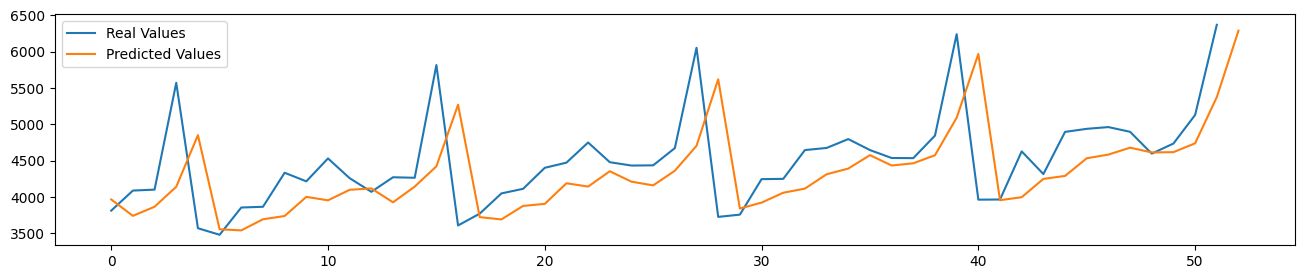

In [22]:
train_generator, test_generator, scaler, model, loss = train_ltsm(beer_wine_liquor['beer'])
plot(beer_wine_liquor['beer'], model, test_generator, scaler)

## simplernn

Epoch 1/10


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\1371248519.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=10)


13/13 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 4/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 5/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 7/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 8/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 9/10
13/13 [==============================] - 0s 2ms/step - loss: 7.9263e-04
Epoch 10/10
13/13 [==============================] - 0s 2ms/step - loss: 7.7371e-04


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3102956838.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = simplernn_model.evaluate_generator(test_generator)


Test Loss for SimpleRNN: 0.01 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


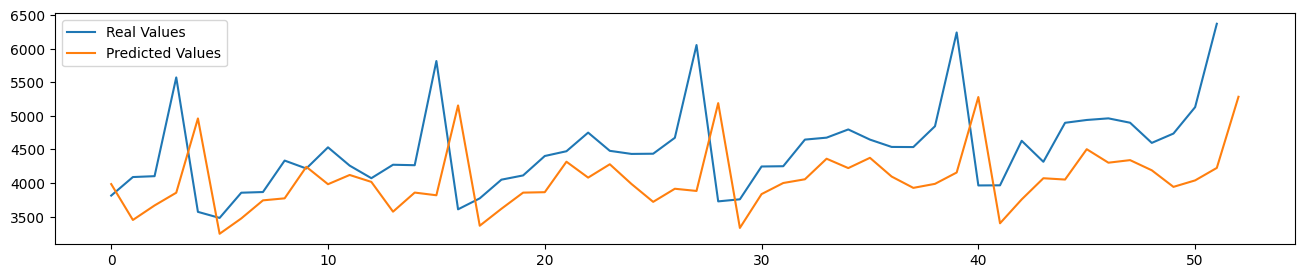

In [23]:
# Construindo e treinando o modelo SimpleRNN
simplernn_model = build_and_train_simplernn_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = simplernn_model.evaluate_generator(test_generator)
print('Test Loss for SimpleRNN: %.2f MSE' % (loss))

plot(beer_wine_liquor['beer'], simplernn_model, test_generator, scaler)

## gru

Epoch 1/10


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3167918330.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=10)


13/13 [==============================] - 1s 5ms/step - loss: 0.0214
Epoch 2/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 8/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 9/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 10/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0066


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3018764403.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = gru_model.evaluate_generator(test_generator)


Test Loss for GRU: 0.02 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


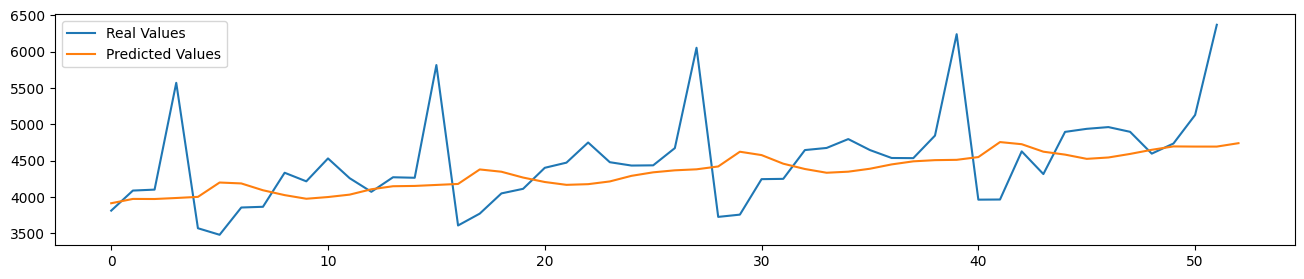

In [24]:
# Construindo e treinando o modelo GRU
gru_model = build_and_train_gru_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = gru_model.evaluate_generator(test_generator)
print('Test Loss for GRU: %.2f MSE' % (loss))

plot(beer_wine_liquor['beer'], gru_model, test_generator, scaler)

## arima

Test Loss for ARIMA: 0.02 MSE


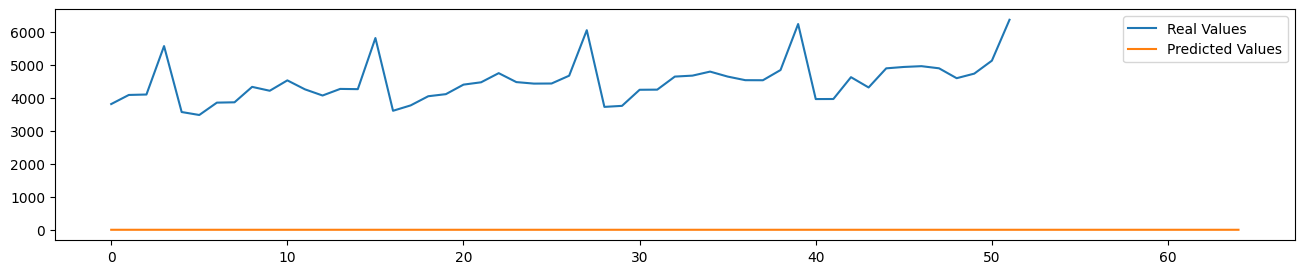

In [25]:
arima_model, arima_model_fit, arima_predictions = train_arima(train_generator, test_generator)
plot_arima(beer_wine_liquor['beer'], arima_predictions)

## sarima

Test Loss for SARIMA: 0.00 MSE


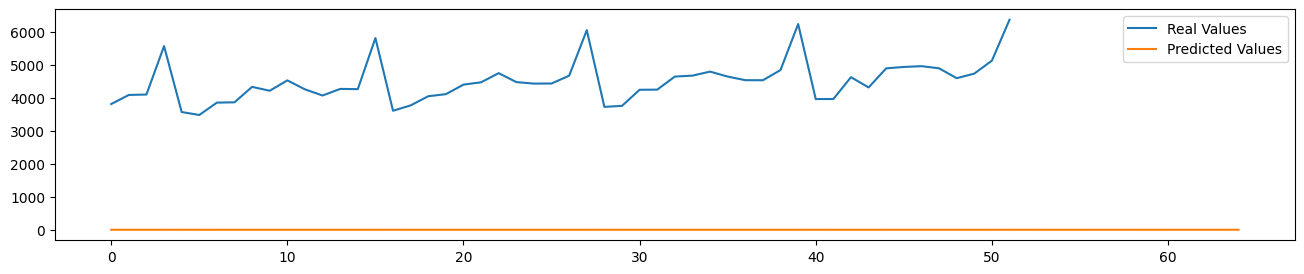

In [26]:
sarima_model, sarima_model_fit, sarima_predictions = train_sarima(train_generator, test_generator)
plot_arima(beer_wine_liquor['beer'], sarima_predictions)

# miles_traveled

## eda

In [27]:
miles_traveled = pd.read_csv('./data/Miles_Traveled.csv')

Miles Traveled Dataset:
         DATE  TRFVOLUSM227NFWA
0  1970-01-01           80173.0
1  1970-02-01           77442.0
2  1970-03-01           90223.0
3  1970-04-01           89956.0
4  1970-05-01           97972.0
       TRFVOLUSM227NFWA
count        588.000000
mean      190420.380952
std        57795.538934
min        77442.000000
25%       133579.000000
50%       196797.500000
75%       243211.500000
max       288145.000000


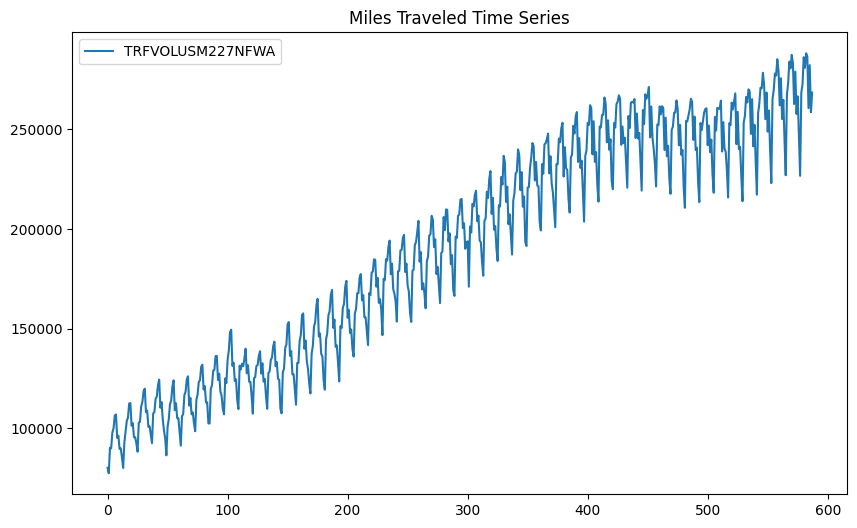

In [28]:
# Dataset miles_traveled
print('Miles Traveled Dataset:')
print(miles_traveled.head())
print(miles_traveled.describe())
plt.figure(figsize=(10, 6))
sns.lineplot(data=miles_traveled)
plt.title('Miles Traveled Time Series')
plt.show()

## ltsm

Epoch 1/50


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3697244598.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=50)


23/23 [==============================] - 1s 5ms/step - loss: 0.1489
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 8/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 9/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 10/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 11/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 12/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 13/50
23/23 [==============================] - 0s 5ms/

C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2619419817.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = model.evaluate_generator(test_generator)


Test Loss: 0.00 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


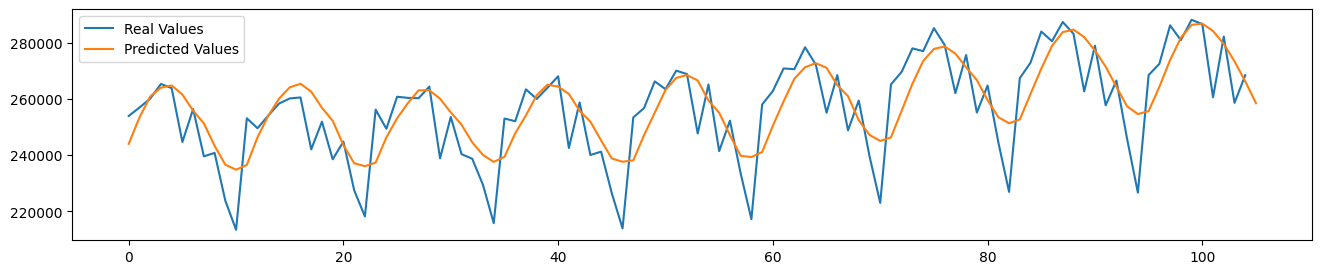

In [29]:
train_generator, test_generator, scaler, model, loss = train_ltsm(miles_traveled['TRFVOLUSM227NFWA'])
plot(miles_traveled['TRFVOLUSM227NFWA'], model, test_generator, scaler)

## simplernn

## gru

Epoch 1/10


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\3167918330.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=10)


23/23 [==============================] - 1s 4ms/step - loss: 0.0715
Epoch 2/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 4/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 6/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 7/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 8/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 9/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 10/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0041


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\1381732579.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss = gru_model.evaluate_generator(test_generator)


Test Loss for GRU: 0.01 MSE


C:\Users\KAIQUEHENRIQUEVALIM\AppData\Local\Temp\ipykernel_21816\2049635450.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator)


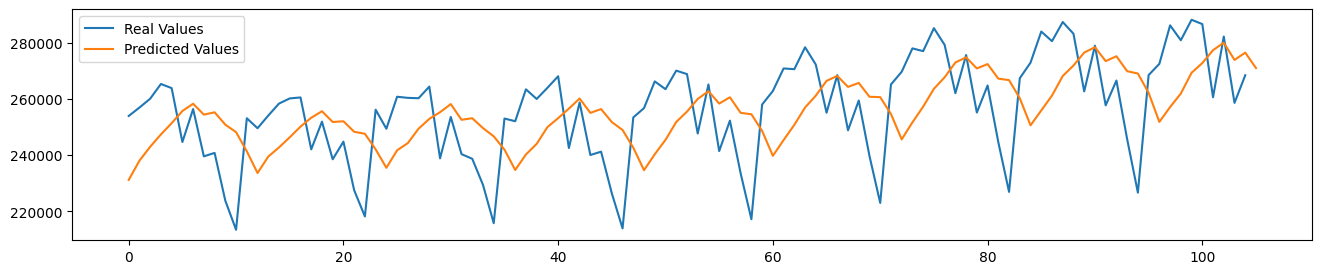

In [30]:
# Construindo e treinando o modelo GRU
gru_model = build_and_train_gru_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = gru_model.evaluate_generator(test_generator)
print('Test Loss for GRU: %.2f MSE' % (loss))

plot(miles_traveled['TRFVOLUSM227NFWA'], gru_model, test_generator, scaler)

## arima

Test Loss for ARIMA: 0.04 MSE


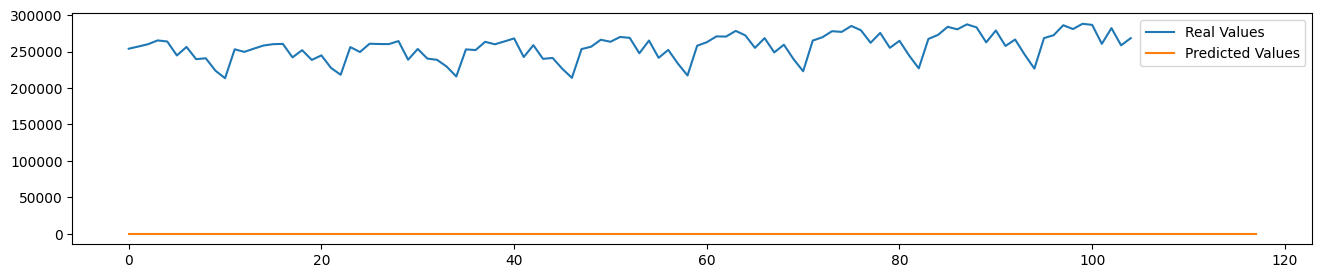

In [31]:
arima_model, arima_model_fit, arima_predictions = train_arima(train_generator, test_generator)
plot_arima(miles_traveled['TRFVOLUSM227NFWA'], arima_predictions)

## sarima

Test Loss for SARIMA: 0.00 MSE


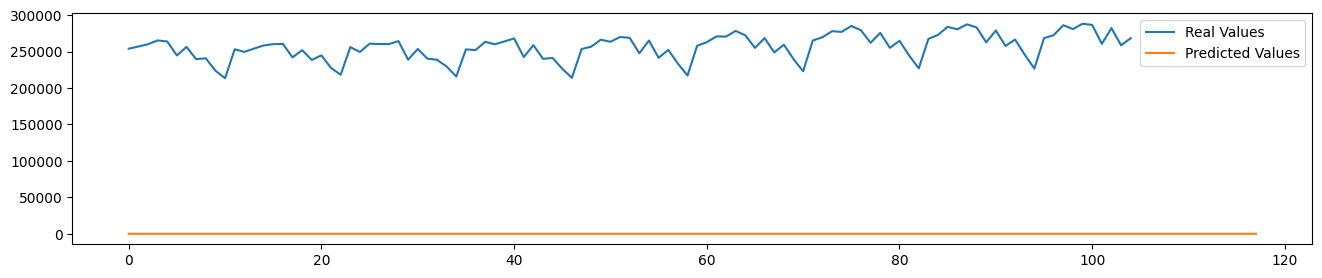

In [32]:
sarima_model, sarima_model_fit, sarima_predictions = train_sarima(train_generator, test_generator)
plot_arima(miles_traveled['TRFVOLUSM227NFWA'], sarima_predictions)